In [1]:
import datetime as datetime
import numpy as np
import pandas as pd
import os
import warnings
import time
import matplotlib.pyplot as plt
import xgboost as xgb

from Data import *
from Speed_Fit import *
from Variance_Fit import *
from Scorer import *

%load_ext autoreload
%autoreload 2

C:\Program Files (x86)\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Intro:
> The goal of this Pricing section is to create a system to calculate theoretical odds prices for horse/jockey combos listed in upcoming races. With theoretical odds we have some benchmark/ starting step for market making strategies / position taking arbitrage. Looking online there are two frequently recurring suggestions for successful modelling of horse races. The first involves speed and variance prediction for individual runners then using monte-carlo for odds calculation. The second and more common suggests using a multionmial logit model as listed in the following research:
[https://www.researchgate.net/publication/292145708_Searching_for_Positive_Returns_at_the_Track](https://www.researchgate.net/publication/292145708_Searching_for_Positive_Returns_at_the_Track)
> The following examples and related code focus on the first method of prediction, but builds a general scoring system and comparison vs betfair-exchange average traded odds to give an intuitive feeling for the accuracy of any available or constructed theoretical odds set 

> Two data sources are looked at in this section:
1. Race data from a 3rd party provider that provides courses length, weather conditions, trainers, weight, age, speed run in race, results etc.
[https://www.racingformbook.com/single-csv-racing-results/](https://www.racingformbook.com/single-csv-racing-results/), included below as './SFF_16_20.csv'
2. A collation of betfair race summary files which include summary trade data such as lowest traded pric, highest traded price, volume weighted average price, close price etc and also results [https://www.racingformbook.com/single-csv-racing-results/](https://www.racingformbook.com/single-csv-racing-results/). These are included below under 'C:\\Users\\mvopa\\Desktop\\Betfair\\data\\UK\\New\\dwbfpricesukwin'

The Data Class reads in data from both sources, matches them together using unique features like name, race number etc and also performs data filtering tasks as described in the filter method. Type = ['b'] are flat races, this is the smallest category as noted in First Exploration.ipynb - to aid with training times & also this is the most common type of races for the larger volume betfair races

In [2]:
test = Data('./SFF_16_20.csv')
test.filter(race_type=['b'])
test.match('C:\\Users\\mvopa\\Desktop\\Betfair\\data\\UK\\New\\dwbfpricesukwin')

62237 races before filtering
1817 races after filtering
1203 races after matching


## To begin:
1. Speed fit: Decision-Tree regression/ linear regression/ xgboost
2. Variance fit: Decision-Tree regression/ linear regression/ constant fit
> All fitting methods give results on train/test R^2 for race general features (no individual runners) and indivdual runners "all", the idea is that from this we gain a better estimate of how much runner specific prediction edge we are gaining as this is what will be useful for determining relative odds - not general race speed prediction accuarcy. Model hyperparameters are optimised by gridsearch elswehere for conciseness

#### Speed Fit / Decision-Tree

In [3]:
fit = Speed_Fit(test.base)
fit.decision_tree_fit(train_split = 0.8, depth = 7 , all_depth = 7)

Decision-Tree-Fit 0.5282 R^2 Race General 
Decision-Tree-Fit 0.3673 R^2 Race General test 
----------
Decision-Tree-Fit 0.5567 R^2 All
Decision-Tree-Fit 0.2462 R^2 All test
----------
Decision-Tree-Fit 0.0285 Horse Specific R^2 diff


#### Speed Fit / Linear

In [4]:
fit = Speed_Fit(test.base)
fit.linear_fit(train_split = 0.8)

Linear-Fit 0.5761 R^2 Race General 
Linear-Fit 0.3865 R^2 Race General test 
----------
Linear-Fit 0.6278 R^2 All
Linear-Fit 0.4328 R^2 All test
----------
Linear-Fit 0.0517 Horse Specific R^2 diff


#### Speed Fit / XGboost

In [5]:
fit = Speed_Fit(test.base)
fit.xgboost_fit()

xgboost 0.5703 R^2 Race General 
xgboost 0.4439 R^2 Race General test 
----------
xgboost 0.6931 R^2 All
xgboost 0.5106 R^2 All test
----------
xgboost 0.0667 Horse Specific R^2 diff


>It's apparent that in order the best models are xgboost -> linear -> decision-tree regression. So we pick xgboost as our speed prediction model. Next to estimate the natural variance of an individual runner, as it's heteroskedastic in the speed regressions. It's not clear to me the best way to do this. My intuition is that better, more experienced horses and trainers have lower variance. We try regression to predict the residual^2 as a rough first estimate. Important to note that we wish not to predict this value exactly, instead just to get an estimation of the aggregate of this value to estimate variance of the inital speed prediction.

#### Variance Fit / Linear

In [6]:
vfit = Variance_Fit(fit.base.copy(),fit.trade_data.copy())
vfit.linear_fit()

Linear-Fit 0.086 R^2 train 
Linear-Fit -0.0848 R^2 test 


#### Variance Fit / Decision-Tree

In [7]:
vfit = Variance_Fit(fit.base.copy(),fit.trade_data.copy())
vfit.decision_tree_fit(depth=4)

Decision-Tree-Fit 0.2717 R^2 train 
Decision-Tree-Fit -0.0415 R^2 test 


#### Variance Fit / Constant

>It appears that our attempt to predict variance doesn't work, perhaps we lack sufficient explanatory features or that the model is poorly formed, I suspect the latter is more likely given the same features found good success in speed prediction. 
So instead we can just use a constant variance fit, gridsearched to pick a good value. We want to develop a good scoring metric to be able to gridsearch and also for insight on how close our predictions are to other readily available odds (e.g. betfair exchange average price odds). We pick the common logistic regression scoring function:
$$Loss = \Sigma -ylog(y') - (1-y) log(1-y')$$

In [8]:
vfit = Variance_Fit(fit.base.copy(),fit.trade_data.copy())

X,Y = [],[]

for i in np.arange(0.05,0.7,0.01):
    vfit.associate_constant(i)
    simulation = Scorer(vfit.final)
    simulation.simulate(1000)
    simulation.score(print_results = False)
    X.append(i)
    Y.append(simulation.score_theo)

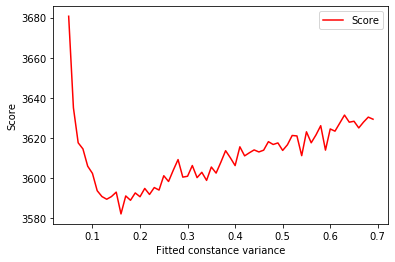

In [9]:
plt.plot(X, Y, color ="red",label='Score')
plt.legend()
plt.xlabel('Fitted constance variance')
plt.ylabel('Score')
plt.show()

We pick 0.15 as the optimised constant variance and see this gives a score of ~3590. We wish to know how this compares to betfair average traded odds and betfair starting price odds. So we calculate:

In [10]:
vfit = Variance_Fit(fit.base.copy(),fit.trade_data.copy())
vfit.associate_constant(0.15)

In [11]:
simulation = Scorer(vfit.final)
simulation.simulate(1000)
simulation.score()

Score from our theoretical odds: 3593.54
Score from PPWAP implied odds: 3110.71
Score from BSP implied odds: 3108.78


>We see our theoretical odds from speed and variance prediction are about 480 points off betfair implied odds, but how much is this difference? To get an idea of a'perfect' score, i.e. how good a perfectly representative prediction vs the actual underlying odds is we can simulate easily a single result for each race based on implied or theoretical odds and then calculate that score. Let's pretend the betfair average price is the actual underlying odds. We will run it a few times and calculate the average total score

### Scoring a perfect odds prediction

In [13]:
frame = fit.trade_data.copy()
sample_list = [Scorer.perfect_score(frame) for i in np.arange(0,10)]
print('Average score from perfect odds prediction: ' + str(np.round(sum(sample_list)/len(sample_list),decimals=2)))

Average score from perfect odds prediction: 3056.13


Note betfair odds are not perfect, about 55 points off, but our prediction score is much further off

## Conclusion

Importantly we have a good scoring/testing framework above for systematic odds predictions. There are 2 obvious areas of focus:
    
1. Better model/training selections
>* Better model selection, e.g. improving upon speed/variance prediction + monte-carlo
>* Better training model selection, linear/xgboost/random forest etc

2. Better feature engineering
>* Better feature construction, more fundamental race intuition or better framework for systematic feature origination
>* Getting more race/runner info

I think the most productive areas for focus are the first bullet points under each list number